In [ ]:
import zipfile
with zipfile.ZipFile('house-prices-advanced-regression-techniques (1).zip', 'r') as zip_ref:
    zip_ref.extractall('house-prices-advanced-regression-techniques')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [3]:
y_train = train['SalePrice']
train = train.drop(['SalePrice'], axis = 1)

In [4]:
types = train.dtypes

In [5]:
types

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [6]:
def check_for_substr(arr, string):
    for elem in arr:
        if elem in str(string):
            return 1
    return 0
    

In [7]:
cols = train.columns
arrs = ['int', 'float']
numerics = []
for col in cols:
    if check_for_substr(arrs, types[col]) == 1:
        numerics.append(col)
        

#### We need to look at the distribution of the target variable

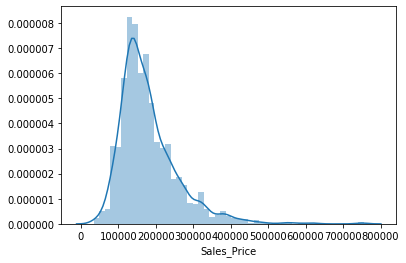

In [8]:
import seaborn as sns
x = pd.Series(y_train, name="Sales_Price")
ax = sns.distplot(x)

#### The distribution is skewed, need to apply log transformation to the data

In [9]:
y_train = np.log1p(y_train)

In [10]:
import seaborn as sn

In [11]:
numerics = numerics[1:]

#### Search for the outliers by plotting dependent variables against the target variable

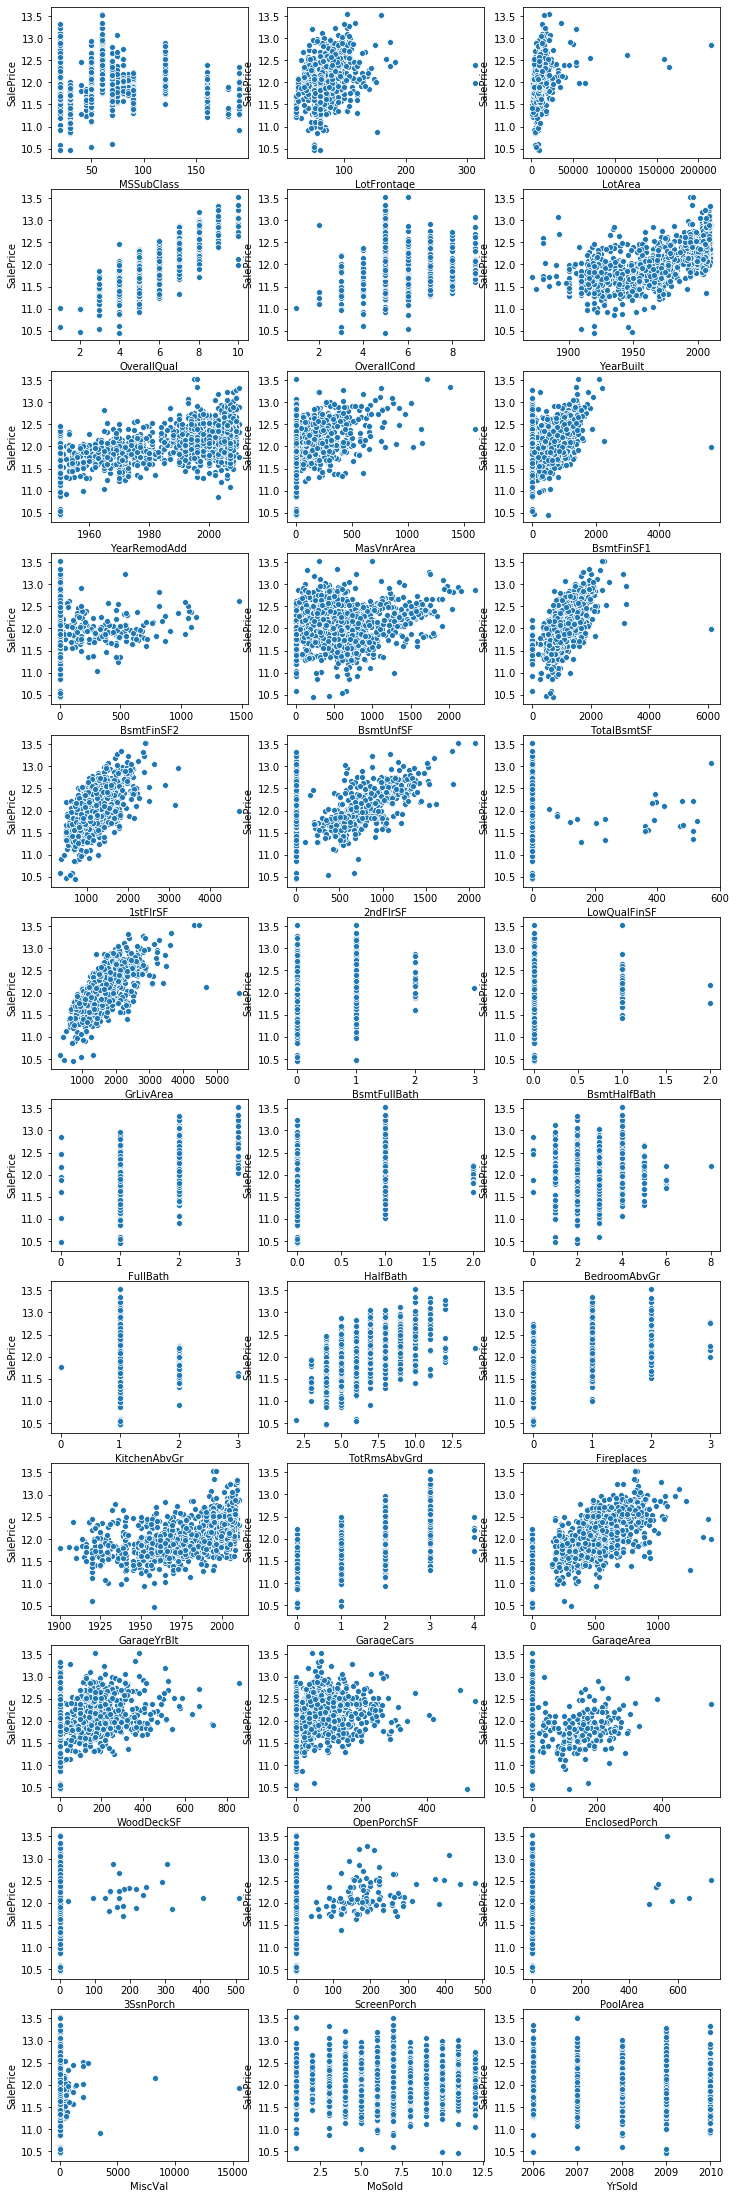

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
i = 1
for col in numerics:
    plt.subplot(len(list(numerics)), 3, i)
    sns.scatterplot(x=col, y='SalePrice' , palette='Blues', data = pd.concat([train, y_train], axis = 1))
    i+=1
    
    

In [13]:
train = pd.concat([train, y_train], axis = 1)

In [14]:
train = train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<12.5)].index)
train = train.drop(train[train['LotArea'] > 200000].index)
train = train.drop(train[train['LotFrontage'] > 300].index)

In [15]:
train = train.reset_index()

### Model 1, let's predict the price of a house using just the Lot Area

In [16]:
mod_1_train = train[['LotArea']]

In [17]:
mod_1_test = test[['LotArea']]

In [18]:
y_train = train['SalePrice']

In [19]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(mod_1_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
preds1 = model1.predict(mod_1_test)

In [21]:
sub1 = pd.read_csv('sample_submission.csv')
sub1['SalePrice'] = np.expm1(preds1)
sub1.to_csv('submission1.csv', index = None)

In [93]:
score_1 = 0.404

### Cross validation score

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5)
kf.get_n_splits(mod_1_train)
errors_mod1 = []
regr = LinearRegression()
for i, (train_index, test_index) in enumerate(kf.split(mod_1_train)):
    X_train, X_test = mod_1_train.loc[train_index], mod_1_train.loc[test_index]
    labels_train, label_test = y_train.loc[train_index], y_train.loc[test_index]
    prediction = regr.fit(X_train, labels_train)
    prediction = regr.predict(X_test)
    error = np.sqrt(mean_squared_error(label_test, prediction))
    errors_mod1.append(error)
print('Cross validation error score for model 1:')
print(np.mean(errors_mod1))

Cross validation error score for model 1:
0.3850815242932769


In [23]:
cross_val_score_1 = 0.38508

# Model 2

### We are going to predict the Sale price using 4 independent variables

In [24]:
mod_2_train = train[['MSSubClass', 'LotArea', 'YearBuilt', 'OverallQual']]

In [25]:
missing_per_col = {}
cols = mod_2_train.columns
for col in cols:
    missing_per_col[col] = mod_2_train[col].isnull().sum()/len(mod_2_train)

In [26]:
mod_2_test = test[['MSSubClass',  'LotArea', 'YearBuilt', 'OverallQual']]

In [27]:
X_mod_2 = pd.concat([mod_2_train, mod_2_test], keys = [0,1])

### It is obvious that Lot area is going to be the most informative feature. However, it is not the only factor, which influences the sale price. It is important to include MSSubClass and Quality to identify the the type of building and its quality.

In [28]:
X_mod_2 = pd.get_dummies(X_mod_2, columns = ['MSSubClass'])

In [29]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_mod_2[['LotArea', 'YearBuilt', 'OverallQual']])

In [30]:
X_mod_2[['LotArea', 'YearBuilt', 'OverallQual']] = x_scaled

In [31]:
from sklearn.linear_model import LinearRegression
mod_2_train = X_mod_2.xs(0)
mod_2_test = X_mod_2.xs(1)

In [32]:
y_train = train['SalePrice']

### Let's now attempt to use simple Linear Regression to predict  Sale Prices of houses

In [33]:
model2 = LinearRegression()
model2.fit(mod_2_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
preds2 = model2.predict(mod_2_test)

In [35]:
sub2 = pd.read_csv('sample_submission.csv')
sub2['SalePrice'] = np.expm1(preds2)
sub2.to_csv('submission2.csv', index = None)

In [36]:
score_2 = 0.1952

### Cross validation score

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5)
kf.get_n_splits(mod_2_train)
errors_mod1 = []
regr = LinearRegression()
for i, (train_index, test_index) in enumerate(kf.split(mod_2_train)):
    X_train, X_test = mod_2_train.loc[train_index], mod_2_train.loc[test_index]
    labels_train, label_test = y_train.loc[train_index], y_train.loc[test_index]
    prediction = regr.fit(X_train, labels_train)
    prediction = regr.predict(X_test)
    error = np.sqrt(mean_squared_error(label_test, prediction))
    errors_mod1.append(error)
print('Cross validation error score for model 2:')
print(np.mean(errors_mod1))

Cross validation error score for model 2:
0.19556958555504927


In [90]:
cross_val_score_2 = 0.19556958555504927

# Model 3

### Now, let's attempt to use all data to predict  the independent variable. However, some features will obviously display collinearity and multicollinearity. We will apply Ridge regression to deal with such issues.

In [39]:
y_train = train['SalePrice']
train = train.drop(['SalePrice'], axis = 1)

In [40]:
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [41]:
train = train.drop(['index', 'Id'], axis = 1)

In [42]:
test = test.drop(['Id'], axis = 1)

In [43]:
X = pd.concat([train,test], keys = [0,1])

In [44]:
missing_per_col = {}
cols = train.columns
for col in cols:
    missing_per_col[col] = X[col].isnull().sum()/len(X)

In [45]:
categorical = list(set(cols) - set(numerics))

In [46]:
for col in categorical:
    X[col] = X[col].fillna(X[col].mode()[0])

for col in numerics:
    X[col] = X[col].fillna(X[col].median())

In [47]:
missing_per_col = {}
cols = train.columns
for col in cols:
    missing_per_col[col] = X[col].isnull().sum()/len(X)

In [48]:
from sklearn.preprocessing import LabelEncoder
X[categorical] = X[categorical].apply(LabelEncoder().fit_transform)

In [49]:
from sklearn.preprocessing import OneHotEncoder
X = pd.get_dummies(X, columns = categorical)

In [50]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X[numerics])

In [51]:
X[numerics] = x_scaled

In [52]:
types = X.dtypes

In [53]:
train = X.xs(0)

In [54]:
test = X.xs(1)

In [55]:
def rmse(pred, true):
    return np.sqrt(mean_squared_error(pred, true))
    

In [60]:
from sklearn.metrics import  make_scorer
scorer = make_scorer(rmse, greater_is_better=False)

In [61]:
params_Ridge = {'alpha': np.arange(0, 1, 0.01)}
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge_gridsearchcv = GridSearchCV(estimator = Ridge(), param_grid=params_Ridge, cv = 5, scoring = scorer)
ridge_gridsearchcv.fit(train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26...
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rm

In [62]:
print('Best score: ', ridge_gridsearchcv.best_score_)

Best score:  -0.1197508710213832


In [63]:
print('Best score: ', ridge_gridsearchcv.best_estimator_)

Best score:  Ridge(alpha=0.99, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5)
kf.get_n_splits(X)
errors_mod3 = []
regr = Ridge(alpha = 0.99)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    X_train, X_test = train.loc[train_index], train.loc[test_index]
    labels_train, label_test = y_train.loc[train_index], y_train.loc[test_index]
    prediction = regr.fit(X_train, labels_train)
    prediction = regr.predict(X_test)
    error = np.sqrt(mean_squared_error(label_test, prediction))
    errors_mod3.append(error)

In [86]:
cross_val_score_3 = np.mean(errors_mod3)

In [87]:
cross_val_score_3

0.1197508710213832

In [69]:
model3 = Ridge(alpha = 0.99)
model3.fit(train, y_train)

Ridge(alpha=0.99, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [70]:
y_preds3 = model3.predict(test)

In [73]:
sub3 = pd.read_csv('sample_submission.csv')
sub3['SalePrice'] = np.expm1(y_preds3)
sub3.to_csv('submission3.csv', index = None)

In [74]:
score_3 = 0.13987

# Model 4

### Now let's test Lasso regression

In [75]:
from sklearn.linear_model import Lasso

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
params_Ridge = {'alpha': np.arange(0.01, 1, 0.01)}
lasso_gridsearchcv = GridSearchCV(estimator = Lasso(), param_grid=params_Ridge, cv = 5, scoring = scorer)
lasso_gridsearchcv.fit(train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmse

In [77]:
print('Best score: ', lasso_gridsearchcv.best_score_)

Best score:  -0.1804841564207979


In [78]:
print('Best estimator: ', lasso_gridsearchcv.best_estimator_)

Best estimator:  Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [79]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
errors_mod4 = []
regr = Lasso(alpha = 0.01)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    X_train, X_test = train.loc[train_index], train.loc[test_index]
    labels_train, label_test = y_train.loc[train_index], y_train.loc[test_index]
    prediction = regr.fit(X_train, labels_train)
    prediction = regr.predict(X_test)
    error = np.sqrt(mean_squared_error(label_test, prediction))
    errors_mod4.append(error)

In [80]:
print('CV score: ', np.mean(errors_mod4))

CV score:  0.1804841564207979


In [88]:
cross_val_score_4 = np.mean(errors_mod4)

In [81]:
model4 = Lasso(alpha = 0.01)
model4.fit(train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [82]:
y_preds4 = model4.predict(test)

In [83]:
sub4 = pd.read_csv('sample_submission.csv')
sub4['SalePrice'] = np.expm1(y_preds4)
sub4.to_csv('submission4.csv', index = None)

In [95]:
score_4 = 0.18885

### Submission scores vs cross val scores graph

In [91]:
cross_vals = [cross_val_score_1, cross_val_score_2, cross_val_score_3, cross_val_score_4]

In [96]:
submissions = [score_1, score_2, score_3, score_4]

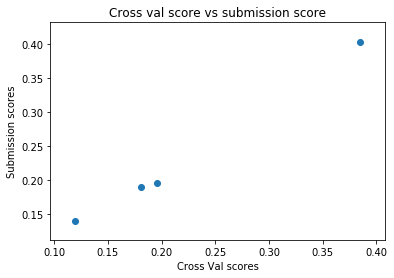

In [99]:
import matplotlib.pyplot as plt
plt.scatter(cross_vals, submissions)
plt.title('Cross val score vs submission score')
plt.xlabel('Cross Val scores')
plt.ylabel('Submission scores')
plt.show()


### We can see that the cross val score gives a good rough estimate of the submission score. The best score is provided by the Ridge regression model, which uses all of the all of the available data.

# Model 5 (Average of all models)

In [105]:
aver = (preds2 + y_preds3 + y_preds4)/3

In [106]:
sub5 = pd.read_csv('sample_submission.csv')
sub5['SalePrice'] = np.expm1(aver)
sub5.to_csv('submission5.csv', index = None)